#### Developing LeNet from scratch

<img src=../images/LeNet5.png width=450>

why conv layers are followed by fully connected layers:

This is because as we reach the final convolutional layer output, the output has small spatial dimensions
(length and width) but a high depth, which makes the output look like an embedding of the input image.
This embedding is like a vector that can be fed into a fully connected network, which is essentially a
bunch of fully connected layers. Besides these layers, there are pooling layers in between. These are
basically subsampling layers that reduce the spatial size of image representation, thereby reducing
the number of parameters and computations as well as effectively condensing the input information.
The pooling layer used in LeNet was an average pooling layer that had trainable weights. Soon after,
max pooling emerged as the most commonly used pooling function in CNNs.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
torch.use_deterministic_algorithms(True) # ensure the reproducibility

In [3]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2, 2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        # all dimensions except the batch dimension
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

# instantiate the model and print the network architecture.
lenet = LeNet()
print(lenet)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [4]:
def train(net, trainloader, optim, epoch):
    loss_total = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        optim.zero_grad()
        outputs = net(inputs)
        loss = nn.CrossEntropyLoss()(outputs, labels) 
        loss.backward()
        optim.step()
        loss_total += loss.item()
        if (i+1) % 1000 == 0:
            print(f'Epoch number {epoch+1}, Mini_batches: {i+1}, Loss: {loss_total/200}')
            loss_total = 0.0

In [5]:
def test(net, testloader):
    success = 0
    counter = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            counter += labels.size(0)
            success += (predicted == labels).sum().item()
    print(f'Accuracy of the network on the 10000 test images: {100 * success / counter}')

##### Loading dataset: CIFAR-10

In [6]:
# The mean and std are kept as 0.5 for normalizing pixel values as the pixel values are originally in the range 0 to 1
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomCrop(32, 4),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True)


test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=False)


# ordering is important
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

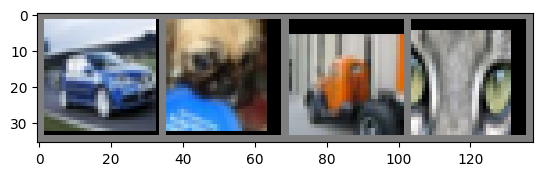

       car || dog || truck || cat


In [7]:
# define a function to plot image
def imageshow(image):
    # un-normalize the image
    image = image / 2 + 0.5
    np_image = image.numpy()
    # Typically, in deep learning frameworks like PyTorch, an image is stored as a NumPy array or tensor with shape:
    # (C, H, W) for a grayscale image or (H, W, C) for an RGB image.
    # However, Matplotlib expects the image to be stored as a NumPy array or tensor with shape (H, W, C) for a grayscale image or (H, W, C) for an RGB image.
    # Therefore, you need to change the shape of the image before displaying it using Matplotlib.
    plt.imshow(np.transpose(np_image, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

num_images = 4
imageshow(torchvision.utils.make_grid(images[:num_images]))
# print labels
print('       '+' || '.join(classes[labels[j]] for j in range(num_images)))

In [ ]:
optim = torch.optim.Adam(lenet.parameters(), lr=0.001)
for epoch in range(50):
    train(lenet, trainloader, optim, epoch)
    print()
    test(lenet, testloader)
    print()
print('Finished Training')

In [13]:
model_path = './cifar_model.pth'
# torch.save(lenet.state_dict(), model_path)

In [14]:
lenet.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-2.3766e-01,  7.0105e-02,  4.6971e-02, -1.5667e-01,  7.4749e-02],
                        [-1.3298e-01,  5.7795e-02, -1.5014e-01, -2.8055e-01,  1.4567e-01],
                        [ 6.2261e-02,  2.3579e-02,  2.5394e-02, -2.5061e-01,  1.6534e-01],
                        [-1.0724e-01, -2.1525e-01, -1.6285e-01, -1.0460e-01,  1.1826e-01],
                        [-9.9971e-02,  1.2714e-03,  1.3875e-01, -2.0665e-01,  5.4005e-02]],
              
                       [[ 3.4432e-02,  3.4714e-02,  1.3374e-01, -9.8841e-02,  1.7222e-01],
                        [ 1.5048e-01,  3.4098e-01,  6.0458e-02, -1.9848e-01,  9.9465e-02],
                        [ 3.0635e-01,  2.4235e-01,  4.2380e-02, -1.5381e-01,  6.2881e-02],
                        [ 9.6224e-02,  8.0121e-03,  9.1366e-02, -9.2393e-02,  1.9262e-01],
                        [-2.3593e-02,  1.6047e-01,  2.5365e-01, -4.4567e-02, -3.5318e-02]],
              
                       [[-1.

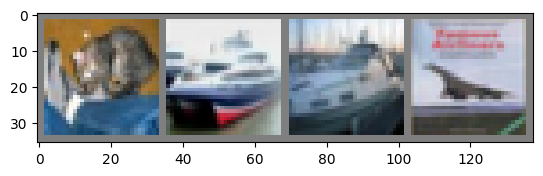

Label:        cat  ship  ship plane
Prediction:     cat  ship  ship plane


In [15]:
d_iter = iter(testloader)
im, ground_truth = next(d_iter)
imageshow(torchvision.utils.make_grid(im[:4]))
print('Label:     ', ' '.join('%5s' %classes[ground_truth[j]] for j in range(4)))

lenet_cached = LeNet()
lenet_cached.load_state_dict(torch.load(model_path))
op = lenet_cached(im)
_, pred = torch.max(op, 1)
print('Prediction:  ', ' '.join('%5s' %classes[pred[j]] for j in range(4)))

In [16]:
lenet_cached

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [18]:
# overall accuracy of the network
success, counter = 0, 0
with torch.no_grad():
    for data in testloader:
        im, ground_truth = data
        op = lenet_cached(im)
        _, pred = torch.max(op, 1)
        counter += ground_truth.size(0)
        success += (pred == ground_truth).sum().item()
print(f'Accuracy of the network on the 10000 test images: {100 * success / counter}')

Accuracy of the network on the 10000 test images: 64.84


In [ ]:
# per-class accuracy of the network
class_success = list(0. for i in range(10))
class_counter = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        im, ground_truth = data
        op = lenet_cached(im)
        _, pred = torch.max(op, 1)
        c = (pred == ground_truth).squeeze()
        for i in range(10000):
            ground_truth_label = ground_truth[i]
            class_success[ground_truth_label] += c[i].item()
            class_counter[ground_truth_label] += 1
for i in range(10):
    print(f'Accuracy of {classes[i]}: {100 * class_success[i] / class_counter[i]}')

Accuracy of plane: 67.9
Accuracy of car: 74.6
Accuracy of bird: 66.8
Accuracy of cat: 33.7
Accuracy of deer: 47.5
Accuracy of dog: 61.5
Accuracy of frog: 78.2
Accuracy of horse: 69.9
Accuracy of ship: 78.5
Accuracy of truck: 69.8
